<h2><center>Dynamic Islanding in Power Systems Based on Real-Time Operating Conditions</center></h2>

<h2><center>Sagnik Basumallik</center></h2>

This tutorial is for the following paper below. 

<h4><center>S. Basumallik and S. Eftekharnejad, "Dynamic Islanding in Power Systems Based on Real-Time Operating Conditions," 2019 North American Power Symposium (NAPS), Wichita, KS, USA, 2019, pp. 1-6.</center></h4>

Full version available on Github: https://github.com/sagnikbm/dynamicIslanding
or ResearchGate https://www.researchgate.net/publication/339333134_Dynamic_Islanding_in_Power_Systems_Based_on_Real-Time_Operating_Conditions.

(Please note the paper on IEEExplore has a typo in equation (5) which unfortunately I was not able to correct even after multiple requests to IEEE. Please access the papers on Github or ResearchGate for the correct version. I apologize for this.)

Please cite the following papers if you find the tutorial helpful:

[1] S. Basumallik and S. Eftekharnejad, "Dynamic Islanding in Power Systems Based on Real-Time Operating Conditions," 2019 North American Power Symposium (NAPS), Wichita, KS, USA, 2019, pp. 1-6

[2] A. Kyriacou, P. Demetriou, C. Panayiotou and E. Kyriakides, "Controlled Islanding Solution for Large-Scale Power Systems," in IEEE Transactions on Power Systems, vol. 33, no. 2, pp. 1591-1602, March 2018.



We demonstrate the process of controlled islanding for a IEEE 14 bus system using Python and Gurobi. The following figure shows the node injections of the original test system in MW. The objective is to partition the system into 2 islands while maintaining load-generation balance.

In [1]:
from IPython.display import Image
Image(filename='input.png') 

The first step involves installing Python, Gurobi and importing associated libraries.

In [2]:
from gurobipy import *
import numpy as np

The next steps is to create the multidictionaries in Python where all related network data is stored. Please install multidict using "pip install multidict"

In [3]:
# this line builds a dictionary of network edges and edge weights

# s = open(r'arcs.txt', 'r').read()
s = open(r'C:/Users/sbasumal/Google Drive/Documents/5. FDIA and Islanding/PycharmProjects/Island/Data/14 bus/arcs.txt', 'r').read()
arcs, weights= multidict(eval("{" + s + "}"))

# this line reads all coherent generator information   (not considered in IEEE 14 bus)

# s = open(r'genCoherentSteiner.txt', 'r').read()
# genCoherentSteiner,genArea= multidict(eval("{" + s + "}"))

# this line reads all nodes and their corresponding load-generation injection values t

# s = open(r'nodes.txt', 'r').read()
s = open(r'C:/Users/sbasumal/Google Drive/Documents/5. FDIA and Islanding/PycharmProjects/Island/Data/14 bus/nodes.txt', 'r').read()
nodes,t= multidict(eval("{" + s + "}"))

# this line reads all Steiner lines corresponding to coherent generators (not considered in IEEE 14 bus)

# s = open(r'lineSteiner.txt', 'r').read()
# lineSteiner,lineArea= multidict(eval("{" + s + "}"))





We first define the number of partitions in the island

In [4]:
area=range(1,3) # number of areas

We then create optimization model. Henceforth, all variables will be associated with model m

In [5]:
m = Model('graphPartition')

Using license file C:\Apps-SU\gurobi900\gurobi.lic
Academic license - for non-commercial use only


Next, we create the variables needed for islanding. These include $x_{i,j}, w_{i,j,h}$ and $z_{i,j}$

In [6]:
##############################################################################################
###########################Partition Variables################################################

#x(i,h) tells if node i is in area(partition) h
x = m.addVars(nodes, area,vtype=GRB.BINARY, name="x")
# w(i,j,h) is the auxiliary variable indicating if edge (i,j) is in area h
w = m.addVars(arcs,area, vtype=GRB.BINARY, name="w")
# z(i,j) indicates whether edge (i,j) would be added to cost
z = m.addVars(arcs, vtype=GRB.BINARY,name="z")

m.update()

Next, we create connectivity variables. The source variable in each island $u_{j,h}$. The flow variable $f$ that ensures connectivity in each island

In [7]:
##############################################################################################
###########################Connectivity Variables#############################################

# u(j,h) indicates if j_th node is the source node in partition h

u = np.zeros((len(nodes)+1,len(area)+1))
u[1,1] = 1
u[14,2] = 1

f1 = m.addVars(arcs,area,name="f")
m.update()

Next, we create imbalance variable $S$ for each island

In [8]:
S=m.addVars(area, name="t")
m.update()

In the next section, we look at building different constraints. The first set of constraints are the partition constraints

The auxiliary variables $w_{i,j,h}$ are related to $x_{i,h}$ as,

\begin{equation}
\begin{aligned}\label{distribute5}
&w_{i,j,h} \leq x_{i,h}&(i,j) \in E,  h\in K \\
&w_{i,j,h} \leq x_{j,h}&(i,j) \in E,  h\in K\\
\end{aligned}
\end{equation}

In [9]:
m.addConstrs(w[i,j,h] <= x[i,h] for i, j in arcs for h in area) 
m.addConstrs(w[i,j,h] <= x[j,h] for i, j in arcs for h in area) 
m.update()

The binary variable $z_{i,j}$ is relaxed using auxiliary variables $w_{i,j,h}$ as,

\begin{equation}
\begin{aligned}
& z_{i,j} = \sum_{h \in K}w_{i,j,h}, &  (i,j) \in E\\
& z_{i,j} = z_{j,i}, & (i,j),(j,i) \in E\\
\end{aligned}
\end{equation}

In [10]:
m.addConstrs(z[i,j] == w.sum(i,j,'*') for i, j in arcs)        
m.addConstrs(z[i,j] == z[j,i] for i,j in arcs)
m.update()

The constraints restricting a node in a single area and ensuring that at least $M$ nodes are in a given area are,

\begin{equation}
\begin{aligned}
&\sum_{h \in K}x_{i,h} = 1, & i \in V\\
&\sum_{ i \in V}x_{i,h} \geq M, & h \in K
\end{aligned}
\end{equation}

In [11]:
m.addConstrs(x.sum(i,'*') == 1 for i in nodes)                  
m.addConstrs(x.sum('*',h) >= 6 for h in area)   
m.update()

The second set of constraints are the connectivity constraints. To ensure each area is connected, a continuous flow variable $f_{i,j,h}$ is introduced,

\begin{equation}
\begin{aligned}
&0 \leq f_{i,j,h} \leq |V|z_{i,j},&&  (i,j) \in E, h \in K
\end{aligned}
\end{equation}

In [12]:
m.addConstrs(0 <= f1[i,j,h] for i,j in arcs for h in area) 
m.addConstrs(f1[i,j,h] <= 14*z[i,j] for i,j in arcs for h in area) 
m.update()

The network flow constrained for $h \in K$ is thus given as,

\begin{equation}
\begin{aligned}
u_{j,h} \sum_{i \in V}x_{i,h} - x_{j,h}+\sum_{\substack{i,j \in V,\\(i,j) \in E}}f_{i,j,h} = \sum_{\substack{{}i,j \in V,\\(j,i) \in E}}f_{j,i,h}
\end{aligned}
\end{equation}

In [13]:
m.addConstrs(u[j,h]*x.sum('*',h)-x[j,h]+f1.sum('*',j,h)==f1.sum(j,'*',h) for j in nodes for h in area)
m.update()

Let the slack variable $S_h$ denote the mismatch in each island $h$ and be defined as $S_h = |\sum_{i=1}^{n}t_i x_{i,h}|$. The slack variable $S_h$ is relaxed using the following two constraints to accommodate the absolute values,


\begin{equation}
\begin{aligned}
\sum_{i=1}^{n}t_i x_{i,h} \geq -S_h  \\
\sum_{i=1}^{n}t_i x_{i,h}  \leq S_h\\
\end{aligned} \label{eq:const}
\end{equation}

In [14]:
m.addConstrs((quicksum(t[i]*x[i,h] for i in nodes) <= S[h] for h in area))
m.addConstrs((quicksum(t[i]*x[i,h] for i in nodes) >= -S[h] for h in area))
m.update()

To reduce the search space of the candidate transmission lines to be disconnected, another constraint is introduced,

\begin{equation}
\begin{aligned}
&z_{i,j} = 1,& (i,j) \in E_{l}
\end{aligned}
\end{equation}
where lines $E_{l} \subset E$ are the set of lines that belong to the Steiner tree connecting all coherent generators in an island. 

In [15]:
# m.addConstrs(z[i,j]==1 for i,j in lineSteiner)
# m.update()

The objective function of minimizing load-generation imbalance is

\begin{equation}
\begin{aligned}\label{distribute}
& {\text{minimize}}
& & \sum_{h=1}^{k} S_h 
\end{aligned}
\end{equation}

In [16]:
m.setObjective(S.sum())

The objective function of minimizing load-generation imbalance can be combined with minimizing total number of lines disconnected,

\begin{equation}
\begin{aligned}\label{distribute}
& {\text{minimize}}
& & \sum_{h=1}^{k} S_h + \sum_{(i,j) \in E}\frac{1}{2}(1-z_{i,j})d_{i,j}
\end{aligned}
\end{equation}

In [17]:
m.setObjective(S.sum()+(0.5*(sum(weights[i,j] for i,j in arcs))-z.prod(weights)))

Next, we set the objective to be minimized and optimize our objectives 

In [18]:
m.modelSense = GRB.MINIMIZE
m.optimize()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (win64)
Optimize a model with 448 rows, 230 columns and 1088 nonzeros
Model fingerprint: 0xa2b02a23
Variable types: 82 continuous, 148 integer (148 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 247 rows and 83 columns
Presolve time: 0.00s
Presolved: 201 rows, 147 columns, 615 nonzeros
Variable types: 76 continuous, 71 integer (70 binary)

Root relaxation: objective -2.000000e+01, 76 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -20.00000    0   51          -  -20.00000      -     -    0s
     0     0  -14.54545    0   53          -  -14.54545      -     -    0s
H    0     0                     166.0000000  -14.54545   109%     -    0s
     0     0  -12.18182   

Print all variables

In [19]:
for v in m.getVars():
    print('%s %g' % (v.varName, v.x))

x[1,1] 1
x[1,2] 0
x[2,1] 1
x[2,2] 0
x[3,1] -0
x[3,2] 1
x[4,1] -0
x[4,2] 1
x[5,1] 1
x[5,2] 0
x[6,1] 1
x[6,2] 0
x[7,1] -0
x[7,2] 1
x[8,1] -0
x[8,2] 1
x[9,1] -0
x[9,2] 1
x[10,1] -0
x[10,2] 1
x[11,1] 1
x[11,2] 0
x[12,1] 1
x[12,2] 0
x[13,1] 1
x[13,2] 0
x[14,1] -0
x[14,2] 1
w[1,2,1] 1
w[1,2,2] -0
w[1,5,1] 1
w[1,5,2] 0
w[2,3,1] 0
w[2,3,2] 0
w[2,4,1] 0
w[2,4,2] 0
w[2,5,1] 1
w[2,5,2] 0
w[3,4,1] -0
w[3,4,2] 1
w[4,5,1] -0
w[4,5,2] 0
w[4,7,1] 0
w[4,7,2] 1
w[4,9,1] -0
w[4,9,2] 1
w[5,6,1] 1
w[5,6,2] 0
w[6,11,1] 1
w[6,11,2] 0
w[6,12,1] 1
w[6,12,2] 0
w[6,13,1] 1
w[6,13,2] 0
w[7,8,1] -0
w[7,8,2] 1
w[7,9,1] 0
w[7,9,2] 1
w[9,10,1] 0
w[9,10,2] 1
w[9,14,1] 0
w[9,14,2] 1
w[10,11,1] 0
w[10,11,2] 0
w[12,13,1] 1
w[12,13,2] 0
w[13,14,1] 0
w[13,14,2] 0
w[2,1,1] 1
w[2,1,2] 0
w[5,1,1] 1
w[5,1,2] 0
w[3,2,1] 0
w[3,2,2] 0
w[4,2,1] -0
w[4,2,2] 0
w[5,2,1] 1
w[5,2,2] 0
w[4,3,1] 0
w[4,3,2] 1
w[5,4,1] 0
w[5,4,2] 0
w[7,4,1] -0
w[7,4,2] 1
w[9,4,1] 0
w[9,4,2] 1
w[6,5,1] 1
w[6,5,2] 0
w[11,6,1] 1
w[11,6,2] 0
w[12,6,1] 1
w[12,6

The partition results for 14 bus is with minimum load-generation imbalance and minimum number of lines disconnected is,

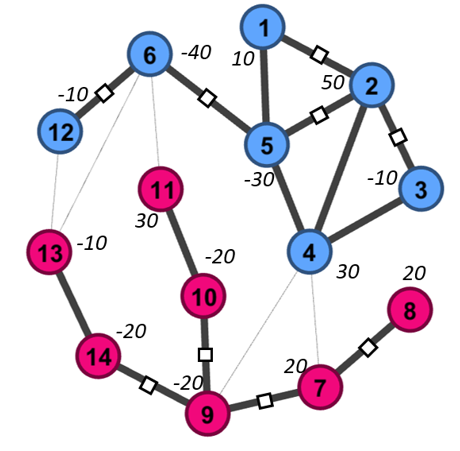

In [20]:
Image(filename='output.png') 

Final Output: There are 2 partitions with 0 MW imbalance in each island with 5 lines disconnected.